# Financial network analysis using graph data structures

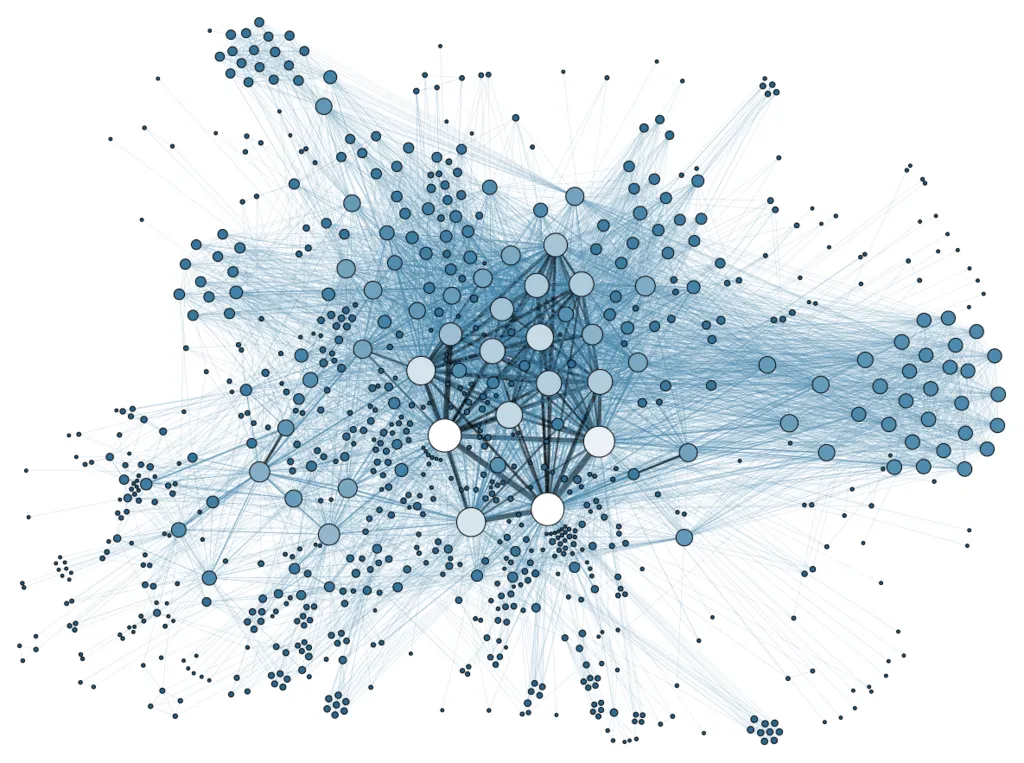

## Disclaimer

-----------------------------------------------------------------------------------------
**This data science notebook is provided for educational purposes only.**

It contains code, analysis, and models that are intended to serve as learning materials and examples. The content is not intended for direct deployment to production environments.

You are encouraged to adapt and modify the contents of this notebook in accordance with the license provided in the associated github repository. However, it is essential to exercise caution, further development, and thorough testing before considering any deployment to production systems.

The authors and contributors of this notebook assume no liability for any consequences, including financial or operational, resulting from the use or misuse of the information and code provided herein. Always consult with appropriate experts and conduct rigorous testing and validation before applying any techniques or models in a real-world, production context.

**By using this notebook, you agree to these terms and conditions.**

-----------------------------------------------------------------------------------------


# Background

## Content

Network science is increasingly entering the supervisory realm:

* [FNA BIS report (network science primer)](https://www.bis.org/ifc/publ/ifcb50_10.pdf)
* [Portugal BIS report (primer, evolution from heatmap to network, conclusions)](https://www.bis.org/ifc/publ/ifcb52_27.pdf)
* [2015 Bank of England speech (visualizations)](https://web.archive.org/web/20150327112210/https://www.bankofengland.co.uk/publications/Documents/speeches/2015/speech812.pdf)

Some questions necessitate a new way of looking at data:

* How is data connected with other data?
* How do these connections matter?
* How do complex systems move in time?

Because of graph data structures and network analysis techniques, for the first time we are able to measure and model this!

## Resources and acknowledgements
The technologies used below will include:
* NetworkX ([library & tutorial](https://networkx.org/documentation/latest/tutorial.html))
* PyVis ([tutorial](https://pyvis.readthedocs.io/en/latest/tutorial.html))

The data we'll use will draw from the following:
* BIS's ["Table 9b" (2013)](https://www.bis.org/statistics/r_qa1406_hanx9b.pdf)
* Now obsoleted and [called B4](https://www.bis.org/statistics/annex_map.htm)
* Can be downloaded from [full datasets repository](https://www.bis.org/statistics/full_data_sets.htm)

Additional relevant supervisory context is covered in:
* [The Political Economy of Global Finance: A Network Model](https://storage.googleapis.com/suptech-lab-practical-data-science-public/Oatleyetal2013.pdf)
* [The Structure and Resilience of the European Interbank Market](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3723333) discusses measures of network centrality including:
    * Connectivity (cloi/exposures & cloo/funding)
    * Proximity (pgrk)
    * Betweenness (bet)
    * Measures of network fragility

Finally, some advanced libraries and additional context-specific supervisory applications are included at the end of this notebook.

## Defining our target

In a [VUCA world](https://hbr.org/2014/01/what-vuca-really-means-for-you) where even some of the most prominent institutions can fail, it's important to understand the implications and how this can propogate through the network.

While this is a deep specialization with a plethora of techniques, we will focus initially on several components. If a node is going to fail, we want to know:

* Which are the most important nodes in the network?
* How many others are connected, and how strong are these connections?
* Are there particular groups that are most susceptible?

To do this, we'll focus on international claims of banks based on their country of residence, but this could be applied to any number of use cases:

* Fraud, AML, and KYC
* DDoS attacks
* Related parties analysis
* Monitoring members
* Designing liquidity efficient FMIs
* Predicting liquidity
* Detecting anomalous transactions

...and more!

## Installing and importing libraries

In [1]:
%%capture
!pip install -qq plotly
!pip install -qq pyvis

# # Have to uninstall to avoid namespace collision of nx.community and python_louvain.community
# # https://stackoverflow.com/a/70178140
!pip uninstall -y networkx
!pip uninstall -y python-louvain
!pip uninstall -y -qq community
# !pip install -qq community
!pip install -qq python-louvain
!pip install -qq networkx
!pip install -qq karateclub

In [2]:
##########################################
# General helper functions and libraries #
##########################################

# General data libs
from assets.getting_started import connect_to_database
import pandas as pd
import numpy as np

# General plotting libs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation
import plotly.express as px
import seaborn as sns

####################
# Modeling process #
####################

# Networks
import networkx as nx
from pyvis.network import Network
from community import community_louvain
from karateclub import EgoNetSplitter

# Data

## Getting the data

Here we take a slightly different approach than some of the other notebooks in the Data Gymnasium.

First off, most of the data available for network analytics have more to do with [websites, collaborations, utility networks](http://networksciencebook.com/translations/en/resources/data.html), [social, political](http://web.stanford.edu/~jacksonm/Data.html) data or otherwise. While the simple examples can be super helfpul for learning the ropes, we want something that relates to the financial sector, and ideally pertains to supervision. Notably that second link contains a dataset for modeling contagion, but it is relatively too advanced for an introductory course.

Because there's not a whole lot of org-level network data out there, and even fewer that are availble in graph database format, we'll start with a tabular dataset published by the BIS, then convert to the graph data from there.

The rationale for converting to graph data is to afford us the ability to use standardized metrics there to understand the important features of the network.

In [3]:
c = connect_to_database()
q = """
  SELECT *
  FROM datagymnasium."foreign_claims"
"""
c.execute(q)
cols = [desc[0] for desc in c.description]
df = pd.DataFrame(c.fetchall(), columns=cols)
df.shape

(174575, 151)

In [4]:
df.columns

Index(['FREQ', 'Frequency', 'L_MEASURE', 'Measure', 'L_REP_CTY',
       'Reporting country', 'CBS_BANK_TYPE', 'CBS bank type', 'CBS_BASIS',
       'CBS reporting basis',
       ...
       '2020-Q4', '2021-Q1', '2021-Q2', '2021-Q3', '2021-Q4', '2022-Q1',
       '2022-Q2', '2022-Q3', '2022-Q4', '2023-Q1'],
      dtype='object', length=151)

## Checking and cleaning the data

Great, we have the data loaded in. Now, to match our target, we need:
* Consolidated foreign claims of reporting banks
* Immediate borrower basis
* On individual countries by nationality of reporting banks
* Amounts outstanding
* End December, 2013
* In millions of US dollars

In [5]:
# Immediate borrower basis
set(df['CBS reporting basis'])

{'Guarantor basis',
 'Immediate counterparty basis',
 'Net risk transfers (Inward-Outward)',
 'Outward risk transfers'}

In [6]:
# Amounts outstanding
set(df['Measure'])

{'Amounts outstanding / Stocks'}

In [7]:
set(df['Remaining maturity'])

{'Over 1 year and up to and including 2 years',
 'Over 2 years',
 'Total (all maturities)',
 'Up to and including 1 year'}

In [8]:
# List the columns we want to keep
cols = [
  'Reporting country',
  'Counterparty country',
  '2013-Q4',
  '2014-Q4',
  '2015-Q4',
  '2016-Q4',
  '2017-Q4'
]

# 1. Make a copy of the original dataframe
# 2. Filter only for the rows we want
# 3. Keep only the columns we want
df1 = df.copy(deep=True)
df1 = df1[(df1['CBS bank type']=="Domestic banks")
      & (df1['CBS reporting basis']=="Immediate counterparty basis")
      & (df1['Balance sheet position']=="Total claims")
      & (df1['Remaining maturity']=="Total (all maturities)")]
df1 = df1[cols]

# Drop the rows containing global aggregates
df1 = df1[(df1['Reporting country']!="All reporting countries") & (df1['Counterparty country']!="All reporting countries") &
         (df1['Counterparty country']!='All countries (total)') & (df1['Counterparty country']!='All countries excluding residents') &
         (df1['Counterparty country']!='International organisations') & (df1['Counterparty country']!='International organisations') &
         (df1['Counterparty country']!='Residents/Local') & (df1['Counterparty country']!='Residents/Local') &
         (df1['Counterparty country']!='Euro area') & (df1['Counterparty country']!='Euro area')]

# Only those who have recorded financial data for the quarter we're looking at
df1 = df1[pd.notnull(df1['2013-Q4'])]

# Change types of Decimals to float
df1 = df1.astype({
    '2013-Q4': float,
    '2014-Q4': float,
    '2015-Q4': float,
    '2016-Q4': float,
    '2017-Q4': float
})

df1

Reporting country Counterparty country    2013-Q4    2014-Q4  \
113            Australia                 Chad      0.008      0.741   
172          Switzerland                 Chad      2.028     18.635   
234               France                 Chad    383.000    662.000   
424        United States                 Chad     35.000     46.000   
513              Austria              Germany  39068.469  37377.994   
...                  ...                  ...        ...        ...   
174270           Denmark             Djibouti      1.000      1.000   
174303            France             Djibouti     30.000     58.000   
174335    United Kingdom             Djibouti     21.000     17.000   
174490            Sweden             Djibouti     18.168     15.395   
174543    Chinese Taipei             Djibouti     88.000     76.000   

          2015-Q4    2016-Q4    2017-Q4  
113         0.301        NaN        NaN  
172         0.212      0.021      0.013  
234       525.000    465.000    491.000  
424        44.000     38.000     39.000  
513     37690.878  35869.525  42703.591  
...           ...        ...        ...  
174270      1.000      1.000      1.000  
174303     10.000     14.000     12.000  
174335     12.000      6.000        NaN  
174490      7.716      1.542      0.351  
174543        NaN        NaN        NaN  

[2674 rows x 7 columns]

In [9]:
set(df1['Reporting country'])

{'Australia',
 'Austria',
 'Belgium',
 'Brazil',
 'Canada',
 'Chile',
 'Chinese Taipei',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Ireland',
 'Italy',
 'Japan',
 'Korea',
 'Mexico',
 'Netherlands',
 'Panama',
 'Portugal',
 'Spain',
 'Sweden',
 'Switzerland',
 'Türkiye',
 'United Kingdom',
 'United States'}

## Preprocessing the data

With only the relevant data in a Pandas dataframe, we can begin to convert this to a graph data structure. The goal here is to convert reporting and counterparty countries to “nodes” in the network, with their “edges” containing the information about their financial relationships in the data. Because there is a reporting country and counterparty country, we also want to represent this relationship as directed nework meaning that each party has a specific role (as opposed to a symmetric or arbitrary relationship that would be best defined as an undirected network).



### Putting into a Graph object

Fortunately, the Python library called [NetworkX](https://networkx.org/) provides a convenient one-line function called [`from_pandas_edgelist`](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html#networkx.convert_matrix.from_pandas_edgelist) to do this work.

In [10]:
# Add nodes
G = nx.from_pandas_edgelist(df1, 'Reporting country', 'Counterparty country', edge_attr=True, create_using=nx.DiGraph)
print("Nodes:", len(G.nodes()), "Edges:", len(G.edges()))

Nodes: 215 Edges: 2674


In [11]:
G['Spain']['Sweden']

{'2013-Q4': 2860.0,
 '2014-Q4': nan,
 '2015-Q4': nan,
 '2016-Q4': nan,
 '2017-Q4': 5846.555}

In [12]:
G['Sweden']['Spain']

{'2013-Q4': 3769.417,
 '2014-Q4': 2791.913,
 '2015-Q4': 2123.155,
 '2016-Q4': 1997.348,
 '2017-Q4': 1801.602}

### Network filtering

Often networks are large and complex and we want to filter out
noise. Filtering techniques give solutions.

Here we filter down to the countries covered in the BIS's historical 9B table (which didn't include Finland as a member), which we'll use for visualizations later on.

In [13]:
short_countries = ['Australia',
                'Austria',
                'Belgium',
                'Brazil',
                'Canada',
                'Chile',
                'Chinese Taipei',
                'Denmark',
                'France',
                'Germany',
                'Greece',
                'Ireland',
                'Italy',
                'Japan',
                'Korea',
                'Mexico',
                'Netherlands',
                'Panama',
                'Portugal',
                'Spain',
                'Sweden',
                'Switzerland',
                'Türkiye',
                'United Kingdom',
                'United States']

df2 = df1[(df1['Reporting country'].isin(short_countries)) & (df1['Counterparty country'].isin(short_countries)) & (df1['Reporting country'] != df1['Counterparty country'])]
G2 = nx.from_pandas_edgelist(df2, 'Reporting country', 'Counterparty country', edge_attr=True, create_using=nx.DiGraph)

# Analysis

Now that everything is loaded into a network, we can begin to answer such questions as:

* What is the overall structure of the network?
* Who are the important people, or hubs, in the network?
* What are the subgroups and communities in the network?


## Descriptive analysis

### Connected components

A connected component or simply component of an undirected graph is a subgraph in which each pair of nodes is connected with each other via a path. A set of nodes forms a connected component in an undirected graph if any node from the set of nodes can reach any other node by traversing edges.

In [14]:
list(nx.connected_components(G.to_undirected()))

[{'Afghanistan',
  'Albania',
  'Algeria',
  'Andorra',
  'Angola',
  'Argentina',
  'Armenia',
  'Aruba',
  'Australia',
  'Austria',
  'Azerbaijan',
  'Bahamas',
  'Bahrain',
  'Bangladesh',
  'Barbados',
  'Belarus',
  'Belgium',
  'Belize',
  'Benin',
  'Bermuda',
  'Bhutan',
  'Bolivia',
  'Bonaire  Sint Eustatius and Saba',
  'Bosnia and Herzegovina',
  'Botswana',
  'Brazil',
  'Brunei',
  'Bulgaria',
  'Burkina Faso',
  'Burundi',
  'Cambodia',
  'Cameroon',
  'Canada',
  'Cape Verde',
  'Cayman Islands',
  'Central African Republic',
  'Chad',
  'Chile',
  'China',
  'Chinese Taipei',
  'Colombia',
  'Comoros',
  'Congo',
  'Congo Democratic Republic',
  'Costa Rica',
  "Cote d'Ivoire",
  'Croatia',
  'Cuba',
  'Curacao',
  'Cyprus',
  'Czechia',
  'Denmark',
  'Djibouti',
  'Dominica',
  'Dominican Republic',
  'Ecuador',
  'Egypt',
  'El Salvador',
  'Equatorial Guinea',
  'Eritrea',
  'Estonia',
  'Eswatini',
  'Ethiopia',
  'Faeroe Islands',
  'Falkland Islands',
  'Fiji',

A strongly connected component is the component of a directed graph that has a path from every vertex to every other vertex in that component. It can only be used in a directed graph.

In [15]:
list(nx.strongly_connected_components(G))

[{'Chad'},
 {'Saudi Arabia'},
 {'Luxembourg'},
 {'India'},
 {'Egypt'},
 {'Jordan'},
 {'Venezuela'},
 {'Bosnia and Herzegovina'},
 {'Barbados'},
 {'Uganda'},
 {'Estonia'},
 {'Malta'},
 {'North Korea'},
 {'Sudan'},
 {'Hong Kong SAR'},
 {'Mauritius'},
 {'Central African Republic'},
 {'Maldives'},
 {'Seychelles'},
 {'Malaysia'},
 {'Qatar'},
 {'United Arab Emirates'},
 {'Israel'},
 {'Congo Democratic Republic'},
 {'Honduras'},
 {'Mozambique'},
 {'Guernsey'},
 {'Bangladesh'},
 {'Kuwait'},
 {'Gibraltar'},
 {'Latvia'},
 {'Georgia'},
 {'Iran'},
 {'Lithuania'},
 {'Liberia'},
 {'Hungary'},
 {'Turks and Caicos Islands'},
 {'Malawi'},
 {'Togo'},
 {'Burkina Faso'},
 {'Jamaica'},
 {'Equatorial Guinea'},
 {'Zambia'},
 {'Gambia'},
 {'Burundi'},
 {'Dominica'},
 {'Yemen'},
 {'Belarus'},
 {'Syria'},
 {'Guatemala'},
 {'Czechia'},
 {'Rwanda'},
 {'Zimbabwe'},
 {'Cayman Islands'},
 {'Kazakhstan'},
 {'Benin'},
 {'Mali'},
 {'Comoros'},
 {'Myanmar'},
 {'Peru'},
 {'San Marino'},
 {'Namibia'},
 {'Croatia'},
 {'Bel

### Degree

The degree is of a node identifies how strongly connected it is to other nodes of a network. This can be done by simply counting the nodes, or by providing a weight from the edges. For our network, we want to weight by value of the connection.

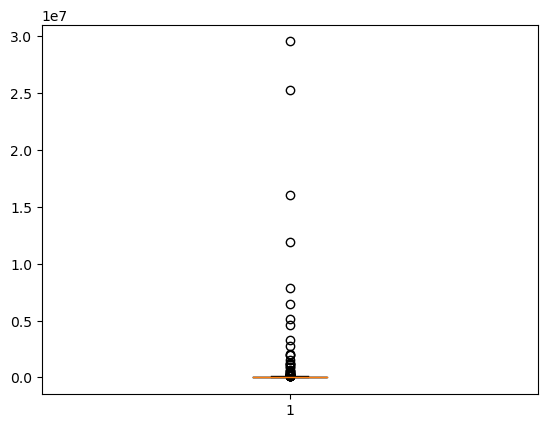

In [16]:
degree_values = [float(v) for k, v in G.degree(weight='2013-Q4')]
fig = plt.figure();
plt.boxplot(degree_values)
plt.show()

## Centrality

There are a variety of network centrality functions we can use in networkx.  We will use several here.  

1. **In-degree centrality** measures how many incoming connections or links are directed towards a node in a directed network.
2. **Out-degree centrality** measures how many outgoing connections or links originate from a node in a directed network.
3. A Node with highest **betweenness centrality** is one that
participates as an “intermediary” in many paths.
4. A Node with the highest **closeness centrality** is the one
that is closer in average to all other nodes in the network
5. **Eigenvector centrality** can be thought of as follows: a node is influential if it's connected with influential nodes. (note that this works best with fully-connected networks; for other networks, Katz centrality can be used)

In code:

1. `Din` = In-degree centrality (networkx divides the in-degree by `nv`-1 so the maximum value =1)

2. `Dout` = Out-degree (networkx divides the out-degree by `nv`-1 so the maximum value =1)

3. `CC` = Closeness centrality (we need to reverse edges of `G` to match networkx convention using the `reverse()` function)

4. `BC` = Betweenness centrality (making the network undirected makes this work better)

5. `EC` = Eigenvector centrality (we need to reverse edges of `G` to match networkx convention  using the `reverse()` function)

We need to be careful with closeness and eigenvector centrality, as their definition of an edge is the reverse of our convention for social networks.

In [17]:
Din = nx.in_degree_centrality(G)
Dout = nx.out_degree_centrality(G)
CC = nx.closeness_centrality(G.reverse())  #reverse edges to match networx convention
BC = nx.betweenness_centrality(G.to_undirected())
EC = nx.eigenvector_centrality(G.reverse())  #reverse edges to match networx convention

### Convert centralities into a dataframe

The centralities calculated by networkx are returned as a *dictionary*.  A dictionary stores data as (key,value) pairs.  To access a value for a key **key** from a dictionary **Dic** you write:  `value = Dic[key]`.

We will convert the dictionaries into lists.  We do this using a `for` loop that goes through every single key (which is a screen name) in the dictionaries, gets the corresponding centrality values, and creates a dictionary of the centralties for this screen name.  Then we append this dictionary to a list called `dictionary_list`.  Then we convert this list of dictionaries into a dataframe with the `DataFrame` command.  The resulting centralties dataframe is called `df_centrality`.



In [18]:
#For plotting, we combine all the centrality dictionaries into a dataframe
dictionary_list = []
for country in Din.keys():
    row = {'country':country,
          'in_degree_centrality':Din[country],
          'out_degree_centrality':Dout[country],
          'closeness_centrality':CC[country],
          'betweenness_centrality':BC[country],
          'eigenvector_centrality':EC[country]}
    dictionary_list.append(row)
df_centrality = pd.DataFrame(dictionary_list)

df_centrality.sort_values(by = ['out_degree_centrality'],ascending = False).head()


country  in_degree_centrality  out_degree_centrality  \
2      Switzerland              0.116822               0.948598   
3           France              0.121495               0.887850   
13  United Kingdom              0.116822               0.855140   
0        Australia              0.107477               0.817757   
4    United States              0.121495               0.813084   

    closeness_centrality  betweenness_centrality  eigenvector_centrality  
2               0.946903                0.156384                0.218025  
3               0.895397                0.112950                0.218025  
13              0.873469                0.099170                0.208945  
0               0.845850                0.111580                0.208945  
4               0.839216                0.084956                0.218025

### Plot top centralities

We will sort the top centralities descending order.  To make one big figure we use the subplot function.

To make our code more efficient, we create a list `Centrality` that contains the name of each column of `df_centrality` that corresponds to a centrality.  Then we run a `for` loop over the centralties in this list, and make a bar plot of the top `kmax` values.  We make subplots for each centrality in one big figure.  There are many plot commands used here to make the figure look nice.  Have a look at them to see what they do.

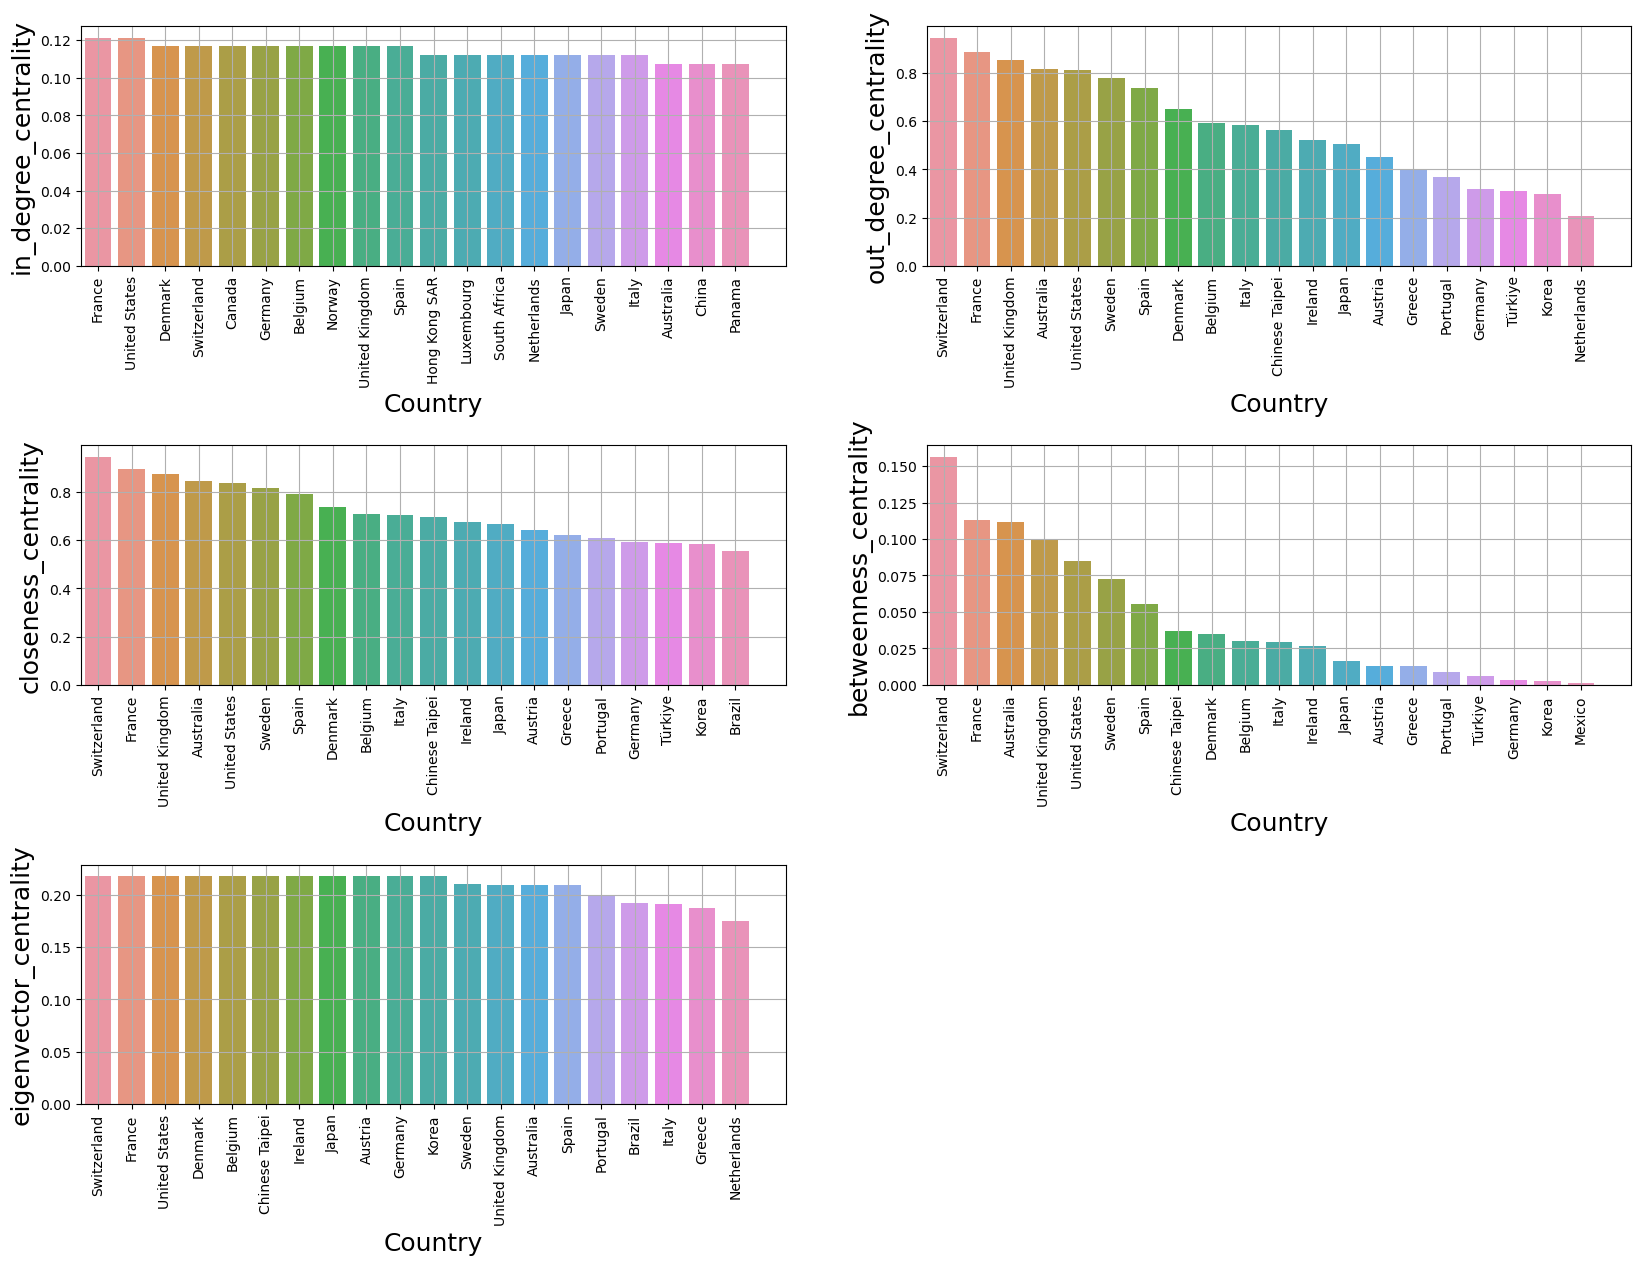

In [19]:
Centrality_names = df_centrality.columns.tolist()[1:]
kmax = 20  #show top kmax users


fig = plt.figure(figsize = (20,14))

for count,centrality_name in enumerate(Centrality_names):
    plt.subplot(3,2,count+1) #make a 2 x 3 subplot, plot in box cnt+1
    df_plot = df_centrality.sort_values(by=[centrality_name],ascending=False).head(n=kmax)  #sort dataframe by centrality value

    ax = sns.barplot(data=df_plot, x='country', y=centrality_name)
    plt.xlim([-.5,kmax+.5])  #set xlimits to only show top kmax users
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)  #rotate axis tick labels 90 degrees
    #plt.xticks(fontsize = 14)
    #plt.yticks(fontsize = 14)
    plt.ylabel(f"{centrality_name}",fontsize = 18)
    plt.xlabel('Country',fontsize = 18)
    plt.grid()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.75)

plt.show()

## Visualizing the data

A few options:
* For small and non-complex (fewer connections) graphs, use inbuilt NetworkX plotting module
* For larger graphs, we can use PyVis as it supports auto-layout (forcing the nodes to be as apart as possible) and provides manual interactions (zoom, drag, select, etc)
* in extreme cases where we want to further play with the network by analyzing the change in network w.r.t. nodes and edges properties, we can use visdcc to plot network in Dash and connect the features to graph with callbacks

[Read more](https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259)

In [20]:
deg = dict(G.degree(weight='2013-Q4'))
deg = {k: v for k, v in sorted(deg.items(), key=lambda item: item[1], reverse=False)}

deg2 = dict(G2.degree(weight='2013-Q4'))
deg2 = {k: v for k, v in sorted(deg2.items(), key=lambda item: item[1], reverse=False)}
deg2

{'Panama': 93430.35500000001,
 'Greece': 117790.129,
 'Chile': 123148.378,
 'Portugal': 205633.2,
 'Türkiye': 220438.972,
 'Chinese Taipei': 262712.63899999997,
 'Austria': 289606.893,
 'Korea': 313989.528,
 'Mexico': 371630.92,
 'Brazil': 476873.78799999994,
 'Belgium': 477661.75800000003,
 'Denmark': 477829.009,
 'Ireland': 535960.972,
 'Sweden': 736121.696,
 'Australia': 759148.249,
 'Italy': 1144511.051,
 'Canada': 1232854.3969999999,
 'Netherlands': 1594188.0270000002,
 'Switzerland': 1735423.7969999998,
 'Spain': 1821684.346,
 'Japan': 2995991.211,
 'Germany': 3373919.6059999997,
 'France': 3382138.685,
 'United Kingdom': 5142528.721,
 'United States': 7510576.535}

In [21]:
fig, axs = plt.subplots(2,3)
fig.set_figheight(11)
fig.set_figwidth(18)

axs[0,0].set_title('nx.draw')
nx.draw(G2, ax=axs[0,0], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

axs[0,1].set_title('nx.draw_networkx')
nx.draw_networkx(G2, ax=axs[0,1], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

axs[0,2].set_title('nx.draw_circular')
nx.draw_circular(G2, ax=axs[0,2], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

axs[1,0].set_title('nx.draw_kamada_kawai')
nx.draw_kamada_kawai(G2, ax=axs[1,0], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

axs[1,1].set_title('nx.draw_random')
nx.draw_random(G2, ax=axs[1,1], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

axs[1,2].set_title('nx.draw_spring')
nx.draw_spring(G2, ax=axs[1,2], node_color="red", node_size=16, edge_color="#cccccc", width=1, font_size=8, with_labels=True)

In [22]:
deg2['United States']

7510576.535

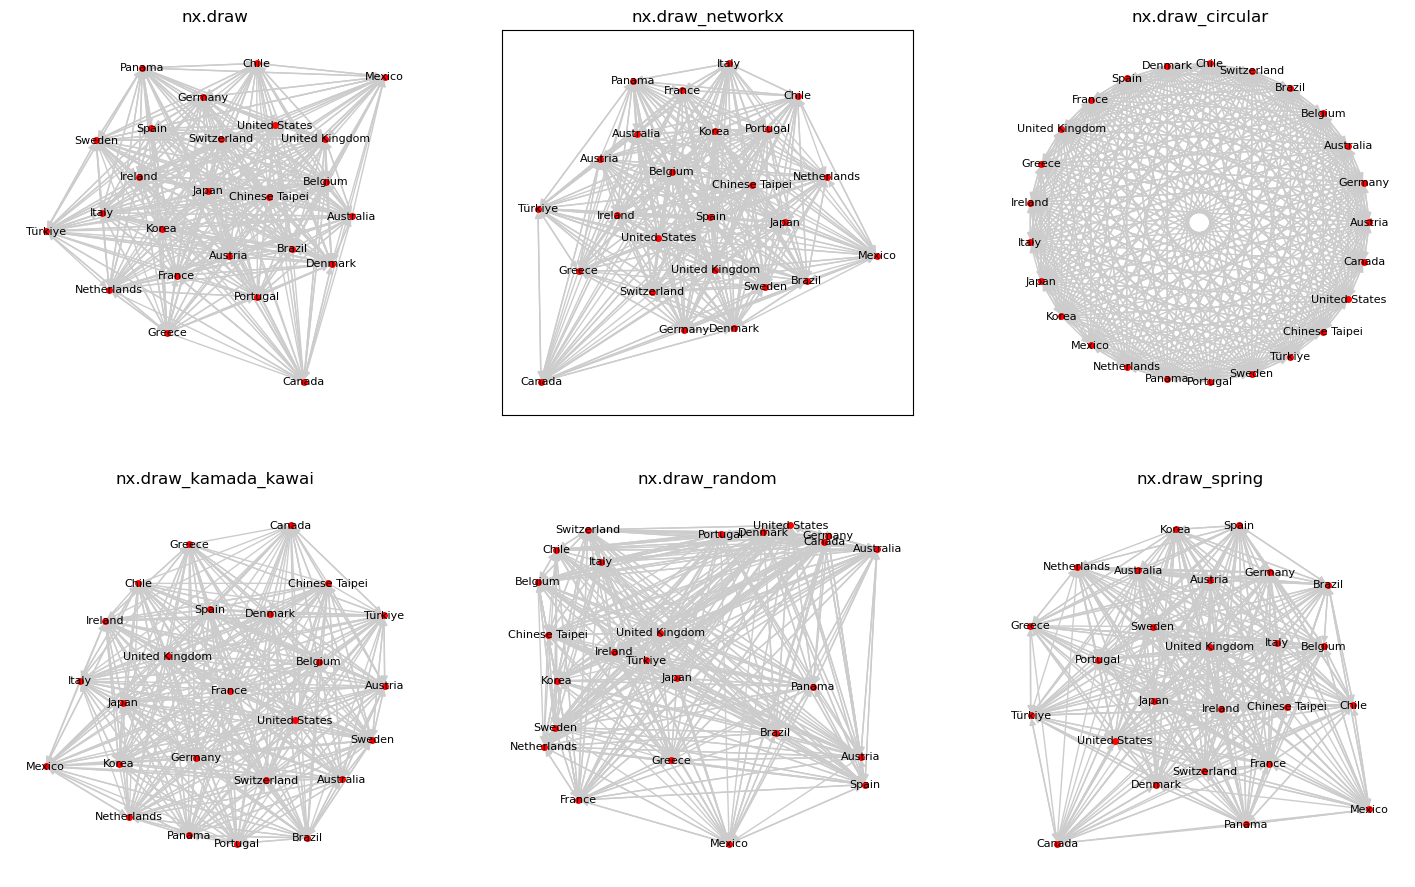

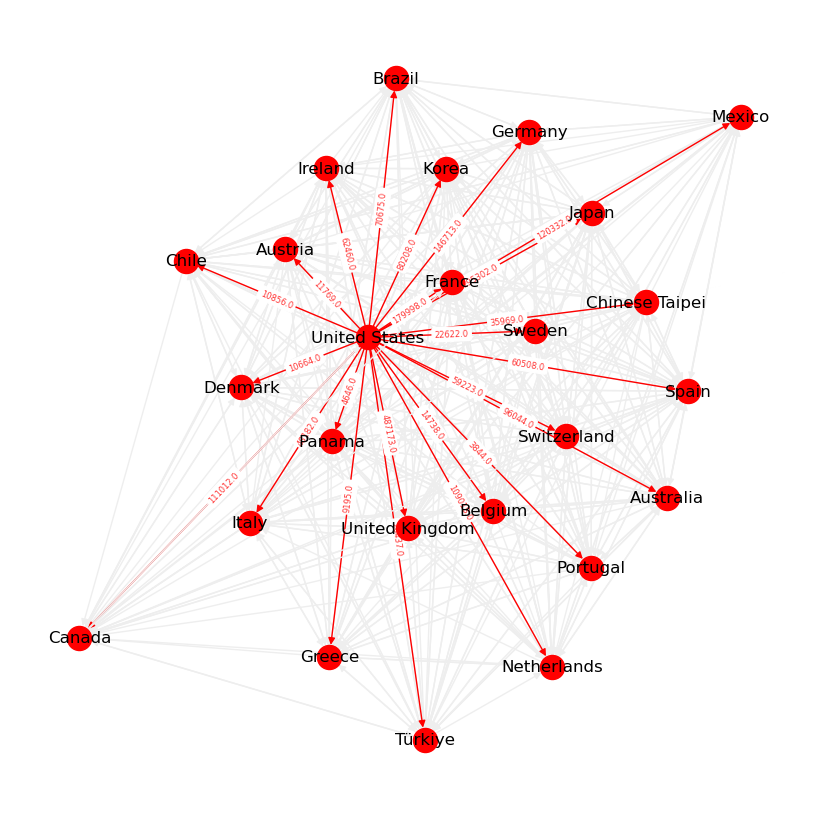

In [23]:
#Draw the network, with labels
edge_colors = ['red' if deg2[e[0]] > 7e6 else '#eeeeee' for e in G2.edges]
edge_labels = dict([((n1, n2), G2[n1][n2]['2013-Q4']) if deg2[n1] > 7e6 else ((n1, n2), "")
                    for n1, n2 in G2.edges])

# Draw
fig = plt.figure(figsize=(8,8))
pos = nx.spring_layout(G2)
nx.draw(G2, pos, node_color = 'red', width= 1,
        edge_color=edge_colors, with_labels=True,font_color = 'black')
nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels, alpha=0.8, font_size=6, font_color='red')
fig.set_facecolor('white')
plt.show()

In [24]:
# See: https://github.com/WestHealth/pyvis/issues/49#issuecomment-853087674
from IPython.core.display import display, HTML

net = Network(notebook=True,
            width="100%",
            height="600px",
            cdn_resources="in_line",
            neighborhood_highlight=False,
            select_menu=False,
           )

net.toggle_hide_edges_on_drag(False)
net.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=10, spring_strength=0.002, damping=0.09, overlap=0)
net.repulsion(2000)

# reuse plotly color palette
palette = px.colors.sequential.Plasma  # 7 colors
factor = len(deg2)/len(palette)

net.from_nx(G2)

for node in net.nodes:
    degree = G2.degree(weight='2013-Q4')[node['label']]
    node['size'] = degree/50000
    node['font'] = {"size": 100}
    node['color'] = palette[int(list(deg2).index(node['label'])/factor)]

for edge in net.edges:
    # get value from main Network weight
    edge['value'] = G2.edges[edge['from'], edge['to']]['2013-Q4']
    edge['font'] = {"size": 40}

net.save_graph("network1.html")

<ipython-input-24-c9ed729c9d1c>:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


To view and interact with the above diagram open the "network2.html" file and click "Trust HTML". You may have to wait for it to load.

We can use this same approach to visualize the entire global network.

**Please note that this takes up to 10 minutes to process before the visualization appears.**

If you would like to run the following code, uncomment the last two lines.

In [25]:
# See: https://github.com/WestHealth/pyvis/issues/49#issuecomment-853087674
from IPython.core.display import display, HTML

net = Network(notebook=True,
            width="100%",
            height="600px",
            cdn_resources="in_line",
            neighborhood_highlight=False,
            select_menu=False,
           )

net.toggle_hide_edges_on_drag(False)
net.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=10, spring_strength=0.002, damping=0.09, overlap=0)
net.repulsion(2000)

# reuse plotly color palette
palette = px.colors.sequential.Plasma  # 7 colors
factor = len(deg)/len(palette)

net.from_nx(G)

for node in net.nodes:
    degree = deg[node['label']]
    node['size'] = degree/50000
    node['font'] = {"size": 100}
    node['color'] = palette[int(list(deg).index(node['label'])/factor)]

for edge in net.edges:
    # get value from main Network weight
    edge['value'] = G.edges[edge['from'], edge['to']]['2013-Q4']
    edge['font'] = {"size": 40}

net.save_graph("network2.html")

<ipython-input-25-1795b1341344>:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


To view and interact with the above diagram open the "network1.html" file and click "Trust HTML". You may have to wait for it to load.

## Community detection

Often networks are large and complex and we want to simplify,
categorize and label nodes into meaningful groups.

Community detection is an algorithmic way of doing this, and
there are numerous methods available.

### Community Louvain method

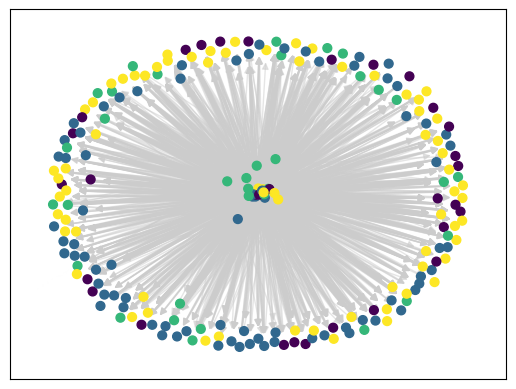

In [26]:
# compute the best partition
partition = community_louvain.best_partition(G.to_undirected())

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5, width=1, edge_color="#cccccc")
plt.show()

In [27]:
df_part = pd.DataFrame(partition.items(), columns=['Country','Partition'])
num_parts = len(set(df_part['Partition']))
num_parts

4

In [28]:
for i in range(0, num_parts):
  print("Group %i" % i)
  display(", ".join(df_part[df_part['Partition']==i]['Country']))
  print("")

Group 0


'Spain, Italy, Portugal, Venezuela, Mauritius, Mozambique, Guernsey, Gibraltar, Latvia, Lithuania, Kazakhstan, Namibia, Croatia, Slovenia, Iceland, Andorra, Moldova, Tunisia, New Zealand, Angola, Uruguay, Guinea-Bissau, Morocco, Cape Verde, Macao SAR, Residual West Indies UK, Ukraine, Algeria, Bulgaria, Cyprus, Liechtenstein'


Group 1


"Switzerland, France, United States, Belgium, Ireland, Mexico, Sweden, Turks and Caicos Islands, Barbados, Uganda, Fiji, Congo Democratic Republic, Central African Republic, Malawi, Honduras, Togo, Burkina Faso, Jamaica, Equatorial Guinea, Gambia, Iran, Burundi, Belarus, Guatemala, Rwanda, Zimbabwe, Vatican City State, Sierra Leone, Mali, Sint Maarten, Comoros, San Marino, U.S. Miscellaneous Pacific Islands, Belize, St Helena  Ascension and Tristan da Cunha, Congo, Colombia, Paraguay, Serbia, Falkland Islands, Ghana, Tajikistan, Grenada, Trinidad and Tobago, Bonaire  Sint Eustatius and Saba, Suriname, Costa Rica, St. Lucia, Nicaragua, Madagascar, Cuba, Sao Tome and Principe, Guyana, Bolivia, Niger, Ethiopia, Somalia, Pakistan, Kenya, El Salvador, Papua New Guinea, Dominican Republic, Residual British Overseas Territories, Turkmenistan, Gabon, Mongolia, Afghanistan, Bahrain, Cote d'Ivoire, Cameroon, Cambodia, Vietnam, Haiti, Unallocated location, Mauritania, Guinea, Ecuador, Oman"


Group 2


'Austria, Germany, Brazil, Chile, Finland, Japan, Korea, Netherlands, Panama, Saudi Arabia, Canada, Luxembourg, India, Malta, Hong Kong SAR, Malaysia, Qatar, United Arab Emirates, Israel, Czechia, Cayman Islands, Peru, Bermuda, Philippines, Poland, Nigeria, Romania, Bahamas, China, Indonesia, South Africa, Norway, Singapore, Thailand, Russia, Argentina'


Group 3


'Australia, Chad, Denmark, United Kingdom, Greece, Türkiye, Chinese Taipei, Egypt, Bosnia and Herzegovina, Jordan, Estonia, North Korea, Sudan, Maldives, Solomon Islands, Seychelles, Bangladesh, Kuwait, Zambia, Georgia, Liberia, Hungary, Dominica, Yemen, Syria, Nauru, Benin, Myanmar, Eritrea, Kiribati, Curacao, Vanuatu, Tuvalu, Faeroe Islands, Tanzania, Greenland, Wallis and Futuna, Albania, Sri Lanka, Montenegro, Marshall Islands, Bhutan, Uzbekistan, Senegal, Jersey, North Macedonia, Brunei, Lebanon, Armenia, Samoa, Tonga, Aruba, Eswatini, Timor Leste, Nepal, Botswana, Slovakia, French Polynesia, New Caledonia, Palestinian Territory, Kyrgyz Republic, Palau, St. Vincent and the Grenadines, Libya, Laos, Micronesia, Iraq, Azerbaijan, Isle of Man, Djibouti'

### Karateclub EgoNetSplitter method

https://hackernoon.com/karate-club-a-python-library-for-graph-representation-learning-05383yh9

In [29]:
Gint = nx.convert_node_labels_to_integers(G.to_undirected(), first_label=0, ordering='default')

splitter = EgoNetSplitter(1.0)

splitter.fit(Gint) #https://github.com/benedekrozemberczki/karateclub/issues/72#issuecomment-866904905

dict_ego = {}
for k,v in splitter.get_memberships().items():
  dict_ego[list(G.nodes)[k]] = v[0]
df_ego = pd.DataFrame(dict_ego.items(), columns=['Country','Partition'])

num_egos = len(set(df_ego['Partition']))
num_egos

8

In [30]:
for i in range(0, num_egos):
  print("Group %i" % i)
  display(", ".join(df_ego[df_ego['Partition']==i]['Country']))
  print("")

Group 0


'Greece, Gibraltar, Latvia, Iran, Iceland, Tanzania, Greenland, Montenegro, Cameroon, Slovakia, Residual West Indies UK, Ukraine, Bulgaria'


Group 1


'Belgium, Congo Democratic Republic, Burundi, Andorra, Ghana, Tajikistan, New Zealand, Angola, Bolivia, El Salvador, Morocco, Bahrain, Mauritania'


Group 2


'Germany, Brazil, Chile, Finland, Japan, Korea, Netherlands, Panama, Portugal, Chinese Taipei, Saudi Arabia, Canada, Luxembourg, India, Malta, Hong Kong SAR, Malaysia, Guernsey, Qatar, United Arab Emirates, Israel, Czechia, Cayman Islands, Peru, Bermuda, Philippines, Tuvalu, Poland, Nigeria, Bahamas, China, Indonesia, South Africa, Macao SAR, Norway, Singapore, Thailand, Russia, Cyprus, Argentina'


Group 3


'Australia, Central African Republic, Solomon Islands, Togo, Kuwait, Nauru, Eritrea, Kiribati, Romania, Bhutan, Tonga, French Polynesia, New Caledonia, Micronesia'


Group 4


'Ireland, Barbados, Uganda, Jamaica, Gambia, Lithuania, Hungary, Vatican City State, U.S. Miscellaneous Pacific Islands, St Helena  Ascension and Tristan da Cunha, Ethiopia, Somalia, Pakistan, Cambodia, Isle of Man'


Group 5


'Chad, Switzerland, France, United States, Spain, United Kingdom, Türkiye, Egypt, Turks and Caicos Islands, Bosnia and Herzegovina, Jordan, Fiji, Sudan, Maldives, Malawi, Equatorial Guinea, Zambia, Georgia, Dominica, Belarus, Rwanda, Kazakhstan, Benin, Sierra Leone, Mali, Sint Maarten, Comoros, San Marino, Namibia, Congo, Curacao, Falkland Islands, Vanuatu, Moldova, Tunisia, Wallis and Futuna, Albania, Grenada, Trinidad and Tobago, Bonaire  Sint Eustatius and Saba, St. Lucia, Madagascar, Sao Tome and Principe, Marshall Islands, Guyana, Niger, Uzbekistan, Guinea-Bissau, Senegal, Jersey, Papua New Guinea, North Macedonia, Brunei, Cape Verde, Residual British Overseas Territories, Samoa, Turkmenistan, Aruba, Gabon, Eswatini, Timor Leste, Haiti, Palestinian Territory, Kyrgyz Republic, Palau, St. Vincent and the Grenadines, Guinea, Libya, Laos, Algeria, Iraq, Azerbaijan, Djibouti'


Group 6


'Italy, Mexico, Venezuela, Honduras, Guatemala, Belize, Colombia, Costa Rica, Cuba, Dominican Republic, Unallocated location, Ecuador'


Group 7


"Austria, Denmark, Sweden, Estonia, North Korea, Mauritius, Seychelles, Mozambique, Burkina Faso, Bangladesh, Liberia, Yemen, Syria, Zimbabwe, Myanmar, Croatia, Slovenia, Paraguay, Serbia, Faeroe Islands, Sri Lanka, Suriname, Nicaragua, Uruguay, Kenya, Lebanon, Armenia, Mongolia, Afghanistan, Nepal, Cote d'Ivoire, Vietnam, Botswana, Oman, Liechtenstein"

## Shortest path



In [31]:
for path in nx.all_simple_paths(G, 'United Kingdom', 'Central African Republic', cutoff=2):
    print(path)

['United Kingdom', 'Sweden', 'Central African Republic']
['United Kingdom', 'France', 'Central African Republic']
['United Kingdom', 'Australia', 'Central African Republic']
['United Kingdom', 'Switzerland', 'Central African Republic']


In [32]:
nx.shortest_path(G, 'United Kingdom', weight='2013-Q4')['Central African Republic']

['United Kingdom', 'Panama', 'Sweden', 'Central African Republic']

# Evolution over time

Let's look at some dynamics over the time period we've selected.

In [33]:
# set up the frames
frames = ['2013-Q4', '2014-Q4', '2015-Q4', '2016-Q4', '2017-Q4']
pos = nx.spring_layout(G2)

# Build plot
fig, ax = plt.subplots(figsize=(8,6))


def update(num):
    ax.clear()
    i = 1
    j = num

    deg_i = dict(G2.degree(weight=frames[num]))
    deg_i = {k: v for k, v in sorted(deg_i.items(), key=lambda item: item[1], reverse=False)}

    edge_colors = ['red' if deg_i[e[0]] > 7e6 else '#eeeeee' for e in G2.edges]
    edge_labels = dict([((n1, n2), G2[n1][n2][frames[num]]) if deg_i[n1] > 7e6 else ((n1, n2), "")
                    for n1, n2 in G2.edges])

    # Background nodes
    nx.draw(G2, pos, node_color = 'red', width= 1,
        edge_color=edge_colors, with_labels=True,font_color = 'black', ax=ax)
    nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels, alpha=0.8, font_size=8, font_color='red', ax=ax)
    fig.set_facecolor('white')

    # Scale plot ax
    ax.set_title("Frame %d:    "%(num+1) +  frames[num], fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])


ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=1000, repeat=True)
HTML(ani.to_jshtml())

# Preparing for next steps

Additional resource are provided below for further research.

**Modeling contagion**:
* Shock transmission: https://cepr.org/voxeu/columns/shock-transmission-through-global-banking-network
* Financial Networks and Contagion: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2175056
* Professor at University of Cambridge: https://sites.google.com/view/matthewlelliott/
  * role of networks in antitrust investigations
  * networks and economic policy

**Other supervisory contexts**:
* For derivatives supervision (HKMA): https://www.hkma.gov.hk/media/eng/publication-and-research/quarterly-bulletin/qb201506/fa.pdf
* Graph pathfinding for FX Liquidity: https://www.linkedin.com/pulse/graph-pathfinding-approach-fx-liquidity-challenges-anthony-butler-gu2he
* Network analytics for social media: https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/Lecture10_NetworkCentrality.ipynb
* Network analytics for fraud detection in banking and finance: https://www.cylynx.io/blog/network-analytics-for-fraud-detection-in-banking-and-finance/
  * Use cases: Fraud rings, synthetic identities, account takeover, insurance fraud
  * Techniques: centrality measures, paths and traversal, entity link analysis, cluster analysis

**More advanced techniques**:
* Graph neural nets for financial networks: https://snap.stanford.edu/graphlearning-workshop/slides/stanford_graph_learning_Finance.pdf
* Literature on graph neural nets (GNNs): https://arxiv.org/abs/2011.08843
* Python library for graph neural nets: https://pyg.org/